In [1]:
using SLMTools, Images, FreeTypeAbstraction, FileIO, Plots
using SLMTools: wrap

Precompiling SLMTools
  ✓ SLMTools
  1 dependency successfully precompiled in 6 seconds. 322 already precompiled.


In [2]:
function mraf(U::LF{Modulus,<:Real,N}, V::LF{Modulus,<:Real,N}, nit::Integer, Φ0::LF{<:Phase,<:Number,N}, roi::CartesianIndices, m::Real) where {N}
    # Runs nit number of iterations of MRAF on the distributions specified by U and V.  Φ0 is a starting phase guess.
    ldq(U, V), elq(U, Φ0)                              # Check for compatibility of the lattices

    U = normalizeLF(U)
    V = normalizeLF(V)
    guess = U * wrap(Φ0)
    R = sqrt(sum(square(sft(guess)).data))      # This compensates non-unitarity of sft.

    for i = 1:nit
        out = sft(guess)
        tar = phasor.(out.data[roi]) .* V.data[roi] * m
        out *= (1-m)/R
        out.data[roi] = tar
        guess = phasor(isft(out)) * U
    end
    return phasor(guess)
end

function ftaText(str::String,sz::Tuple{Int,Int}; fnt = "arial bold",pixelsize::Union{Int,Nothing}=nothing,halign=:hcenter,valign=:vcenter,options...)
    if isnothing(pixelsize)
        pixelsize = sz[2] ÷ length(str)
    end
    face = findfont(fnt)
    x0, y0 = sz .÷ 2
    arr = zeros(UInt8,sz...)    # Text will go here
    renderstring!(arr,str,face,pixelsize, x0, y0; halign=halign, valign=valign, options...)
    return convert.(Float64,arr)./255
end

function plotToImage(p::Plots.Plot)
    io = IOBuffer()
    show(io, MIME("image/png"), p);
    strm = Stream(format"PNG", io)
    img = load(strm);
    return img
end

function imageToHeatmap(img::Matrix{T};options...) where T<:Union{Number,Gray}
    return heatmap(convert.(Float64,img);options...)
end

function grayAnnotation(text::String,pixelsize::Int,padto::Union{Nothing,Tuple{Int,Int}}=nothing; options...)
    a = ftaText(text,(round(Int,pixelsize*2),round(Int,pixelsize*2));pixelsize=pixelsize,options...)
    ax = sum(a;dims=2)
    ay = sum(a;dims=1)
    xl = findfirst(!=(0),ax[:])
    xu = findlast(!=(0),ax[:])
    yl = findfirst(!=(0),ay[:])
    yu = findlast(!=(0),ay[:])
    a = convert.(Gray{Float64},a[xl:xu,yl:yu])
    if isnothing(padto)
        return a
    else
        if any(padto .< size(a))
            error("grayAnnotation: Text size exceeds target output size (`padto`).")
        end
        output = zeros(Gray{Float64},padto)
        output[CartesianIndices(size(a)) .+ CartesianIndex((padto .- size(a)) .÷ 2)] = a
        return output
    end
end

function colorPromote(arr::Array{T}) where T<:Matrix
    arr2 = copy(arr)
    if any(M[1] isa RGB for M in arr)
        for i=1:length(arr)
            arr2[i] = RGB.(arr[i])
        end
    end
    return arr2
end

function padout(M::Matrix{T},s::Tuple{Int,Int},fillval=zero(T); shift::Union{Nothing,CartesianIndex}=nothing) where T<:Union{Number,Gray,RGB}
    if any(s .< size(M))
        error("padout: Matrix is bigger than intended padded size.")
    end
    output = fill(convert(T,fillval),s)
    if isnothing(shift)
        shift = CartesianIndex((s .- size(M)) .÷ 2)
    end
    output[CartesianIndices(size(M)) .+ shift] = M
    return output
end

function padadd(M::Matrix{T},s::Int,side::Symbol,fillval=zero(T)) where T<:Union{Number,Gray,RGB}
    CI = CartesianIndices(size(M))
    if side in [:l,:L,:left,:Left]
        output = fill(convert(T,fillval), size(M) .+ (0,s))
        output[CI .+ CartesianIndex(0,s)] = M
    elseif side in [:r,:R,:right,:Right]
        output = fill(convert(T,fillval), size(M) .+ (0,s))
        output[CI] = M
    elseif side in [:t,:T,:top,:Top]
        output = fill(convert(T,fillval), size(M) .+ (s,0))
        output[CI .+ CartesianIndex(s,0)] = M
    elseif side in [:b,:B,:bottom,:Bottom]
        output = fill(convert(T,fillval), size(M) .+ (s,0))
        output[CI] = M
    end
    return output
end

function padmultiple(M::Matrix{T}; padleft::Int=0,padright::Int=0,padtop::Int=0,padbottom::Int=0,padall::Int=0,fillval=0) where T<:Union{Number,Gray,RGB}
    output = copy(M)
    if padleft > 0
        output = padadd(output,padleft,:L,fillval)
    end
    if padright > 0 
        output = padadd(output,padright,:R,fillval)
    end
    if padtop > 0
        output = padadd(output,padtop,:T,fillval)
    end
    if padbottom > 0
        output = padadd(output,padbottom,:B,fillval)
    end
    if padall > 0 
        output = padmultiple(output; padleft=padleft,padright=padright,padtop=padtop,padbottom=padbottom, fillval=fillval)
    end
    return output
end

function padmultiple(arr::Array{T}; padleft::Int=0,padright::Int=0,padtop::Int=0,padbottom::Int=0,padall::Int=0,fillval=0) where T<:Matrix
    output = copy(arr)
    for i=1:length(output)
        output[i] = padmultiple(output[i]; padleft=padleft,padright=padright,
            padtop=padtop,padbottom=padbottom,padall=padall, fillval=fillval)
    end
    return output
end

function padCommon(arr::Matrix{T},fillval=nothing) where T<:Matrix
    arr = colorPromote(arr)
    S = typeof(arr[1][1])
    if isnothing(fillval)
        fillval = zero(S)
    end
    n,m = size(arr)
    sx = Tuple( maximum(size(arr[j,k],1) for k=1:m) for j=1:n)
    sy = Tuple( maximum(size(arr[j,k],2) for j=1:n) for k=1:m)
    output = Array{Matrix}(undef,n,m)
    for j=1:n
        for k=1:m
            output[j,k] = padout(arr[j,k],(sx[j],sy[k]),fillval)
        end
    end
    return output
end

function trimWhitespace(M::Matrix{T}) where T<:Union{Number,Gray,RGB}
    n,m = size(M)
    Mg = Gray.(M)
    tx = Tuple(minimum(Mg[j,:]) for j=1:n)
    ty = Tuple(minimum(Mg[:,k]) for k=1:m)
    xl = findfirst(!=(1),tx)
    xu = findlast(!=(1),tx)
    yl = findfirst(!=(1),ty)
    yu = findlast(!=(1),ty)
    return M[xl:xu,yl:yu]
end

function arrange(layout::Tuple,Ms...)
    output = Array{Matrix}(undef,layout...)
    for i=1:length(output)
        output[i] = Ms[i]
    end
    return output
end

function checkCommonSize(arr::Matrix{T}) where T<:Matrix
    n,m = size(arr)
    all( all(size(arr[j,k],1) == size(arr[j,1],1) for k=1:m) for j=1:n) &&
    all( all(size(arr[j,k],2) == size(arr[1,k],2) for j=1:n) for k=1:m)
end
function checkCommonSize(arr::Vector{T}) where T<:Matrix
    n = length(arr)
    all(size(arr[j],2) == size(arr[1],2) for j=1:n)
end


function mergeStrict(arr::Array{T}; padleft::Int=0,padright::Int=0,padtop::Int=0,padbottom::Int=0,padall::Int=0,fillval=0) where T<:Matrix
    a = copy(arr)
    layout = size(arr)
    if !checkCommonSize(a)
        error("mergeStrict: Images have incompatible sizes.")
    end
    b = colorPromote(a)
    b = padmultiple(b;padleft=padleft,padright=padright,padtop=padtop,padbottom=padbottom,padall=padall,fillval=fillval)
    return vcat( (hcat(b[j,:]...) for j=1:layout[1])... )
end

function mergeStrict(layout::Tuple{Int,Int},Ms::Matrix...; padleft::Int=0,padright::Int=0,padtop::Int=0,padbottom::Int=0,padall::Int=0,fillval=0)
    a = arrange(layout,Ms...)
    if !checkCommonSize(a)
        error("mergeStrict: Images have incompatible sizes.")
    end
    b = colorPromote(a)
    b = padmultiple.(b;padleft=padleft,padright=padright,padtop=padtop,padbottom=padbottom,padall=padall,fillval=fillval)
    return vcat( (hcat(b[j,:]...) for j=1:layout[1])... )
end

function mergeFill(arr::Array{T}; padleft::Int=0,padright::Int=0,padtop::Int=0,padbottom::Int=0,padall::Int=0,fillval=0) where T<:Matrix
    a = copy(arr)
    layout = size(arr)
    b = colorPromote(a)
    if !checkCommonSize(b)
        b = padCommon(b,fillval)
    end
    b = padmultiple(b;padleft=padleft,padright=padright,padtop=padtop,padbottom=padbottom,padall=padall,fillval=fillval)
    return vcat( (hcat(b[j,:]...) for j=1:layout[1])... )
end

function mergeFill(layout::Tuple{Int,Int},Ms::Matrix...; padleft::Int=0,padright::Int=0,padtop::Int=0,padbottom::Int=0,padall::Int=0,fillval=0)
    a = arrange(layout,Ms...)
    b = colorPromote(a)
    if !checkCommonSize(b)
        b = padCommon(b,fillval)
    end
    b = padmultiple(b;padleft=padleft,padright=padright,padtop=padtop,padbottom=padbottom,padall=padall,fillval=fillval)
    return vcat( (hcat(b[j,:]...) for j=1:layout[1])... )
end


function autoAnnotate(arr::Array{T},pixelsize::Int,padto::Union{Nothing,Tuple{Int,Int}}=nothing; 
        labelOffset::Int=0, location::Symbol=:topleft, shift::CartesianIndex=CartesianIndex(0,0), options...) where T<:Matrix
    labels = Tuple(string('(',Char(i),')') for i in [97:122...,65:90...])[(1:length(arr)) .+ labelOffset]
    return handAnnotate(arr,labels,pixelsize,padto;location=location,shift=shift,options...)
end

function handAnnotate(M::Matrix{T},text::String,pixelsize::Int,padto::Union{Nothing,Tuple{Int,Int}}=nothing; 
        location::Symbol=:topleft, shift::CartesianIndex=CartesianIndex(0,0), inverta=true, options...) where T<:Union{Number,Gray,RGB}
    output = copy(M)
    a = grayAnnotation(text,pixelsize,padto; options...)
    if inverta
        a = 1 .- a
    end
    if T <: RGB
        a = RGB.(a)
    end
    if location == :topleft
        output[CartesianIndices(size(a)) .+ shift] = a
    else
        println("handAnnotate warning: This location is not yet implemented.  No change made.")
    end
    return output
end

function handAnnotate(arr::Array{T},labels::NTuple{N,String},pixelsize::Int,padto::Union{Nothing,Tuple{Int,Int}}=nothing; 
        location::Symbol=:topleft, shift::CartesianIndex=CartesianIndex(0,0), options...) where {N,T<:Matrix}
    output = copy(arr)
    for i=1:length(output)
        output[i] = handAnnotate(output[i],labels[i],pixelsize,padto; location=location, shift=shift, options...)
    end
    return output
end

handAnnotate (generic function with 4 methods)

In [3]:
N = 128
L0 = natlat((N,N))

(-5.65685424949238:0.08838834764831843:5.568465901844061, -5.65685424949238:0.08838834764831843:5.568465901844061)

Intensity, modulus, phase:


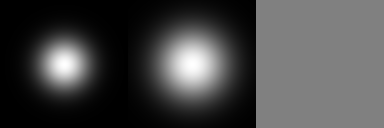

In [4]:
# Generate input beam
I = LF{ComplexAmp}( exp.(-r2(L0) ./ (3 + 0im)^2) , L0 )
println("Intensity, modulus, phase:")
look(square(I),I)

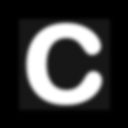

In [5]:
# Generate target intensity
C = lfRect(I|>square,(4,4))*0.1 + lfText(Intensity,"c"; lfTemplate=I, pixelsize=150)    # Letter c on low background
C = LF{Intensity}(imfilter(C.data, Kernel.gaussian(2)),C.L)                             # Blur the edges slightly
look(C)

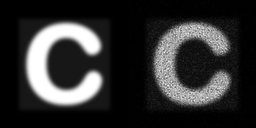

In [6]:
Φgs = gs(abs(I),sqrt(C),10000,wrap(LF{RealPhase}(rand(size(C)...),C.L)))    # Generate phase w/ GS + random initialization
look(C,square(sft(I * Φgs)))

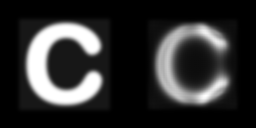

In [7]:
Φot = otPhase(square(I),C,0.001)     # Generate phase w/ OT
look(C,square(sft(I * Φot)))

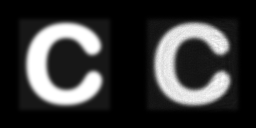

In [8]:
Φotgs = gs(abs(I),sqrt(C),10000,wrap(Φot))    # Generate phase w/ GS + OT initialization
look(C,square(sft(I * Φotgs)))

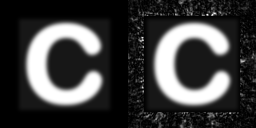

In [9]:
Φotmraf = mraf(abs(I),sqrt(C),10000,wrap(Φot),CartesianIndices((17:112,17:112)),0.48)
look(C,square(sft(I * Φotmraf)))

In [10]:
# Evaluate RMS error for each phase
for Φ in [Φgs,Φot,Φotgs,Φotmraf]
    println(SchroffError(C,square(sft(abs(I) * Φ))))
end

0.1380471212814063
0.17376155397833687
0.0273470904731181
5.465265329226124e-16


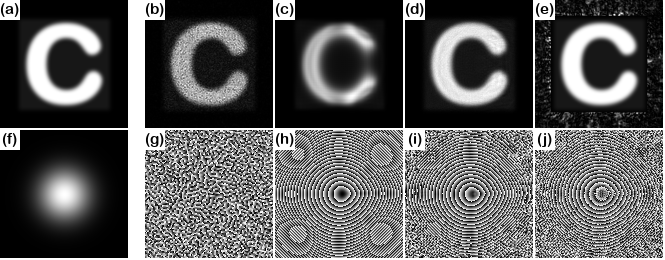

In [11]:
# Merge images
phases = [Φgs,Φot,Φotgs,Φotmraf]
outbeams = [square(sft(abs(I) * Φ)) for Φ in phases];
anns = handAnnotate(look.([C outbeams... ; square(I) phases...]), 
    ("(a)","(f)","(b)","(g)","(c)","(h)","(d)","(i)","(e)","(j)"),15,(20,20))
anns[:,1] = padadd.(anns[:,1],15,:r,1)
fig = mergeStrict(anns; padright = 2, padbottom=2, fillval=1)